In [70]:
#coding:utf8
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor

In [61]:
def load_data(em_data = True, veh_data = True, air_data = True):
    args = []
    if em_data:
        EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
        EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
        UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 15)
        US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
        EU_em_df = EU_em_df.set_index('Month')
        EU_em_annual_df = EU_em_df.groupby(np.arange(len(EU_em_df))//(12)).sum()
        EU_em_annual_df.index = np.linspace(1973, 2021, EU_em_annual_df.shape[0], dtype=np.int32)
        UK_em_df = UK_em_df.transpose()
        UK_em_df.columns = UK_em_df.iloc[0, :]
        UK_em_df = UK_em_df.drop('Year')
        US_em_df = US_em_df.transpose()
        US_em_df.columns = US_em_df.iloc[0, :]
        US_em_df = US_em_df.replace('+', 0)
        US_em_df = US_em_df.drop('Year')
        args += [EU_em_df, EU_em_annual_df, UK_em_df, US_em_df]
    if veh_data:
        EU_veh_df = pd.read_csv('Data/EU_veh.csv')
        UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 76)
        US_veh_df = pd.read_excel('Data/US_veh.xlsx')
        args += [EU_veh_df, UK_veh_df, US_veh_df]
    if air_data:
        # Secondary Data 
        # Air pollution
        # UK 1970-2019/2022
        UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
        UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
                
        # USA Since 1970-2020, plz Access through column id(numbers)
        USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
        USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
        USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
        
        USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
        USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
                
        # OCED DATA
        OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx')
    
    args += [UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df]
        
    return args

def train_test_split(X, y, split_point):
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test

def normalise(X):
    X_attrs = np.zeros((X.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    return X, X_attrs
        
def create_model(layers, input_shape):
    # Create and compile model
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

def run_model(x_train, x_test, y_train, y_test, data_memory, samples, epochs, batch_size, model_des, plot_pred, plot_range):
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    mse = metrics.MeanSquaredError()
    mse.update_state(y_norm, y_pred_norm)
    test_loss = mse.result().numpy()
    y = (y_norm/X_attrs[-1, 1]**0.5) + X_attrs[-1, 0]
    y_pred = np.roll(y_pred_norm /X_attrs[-1, 1]**0.5 + X_attrs[-1, 0] , -time_step)
    print(test_loss)
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    model_performance = [time_step, data_memory, samples, model_des, epochs, batch_size, train_loss, val_loss, test_loss]
    df_model = pd.DataFrame(model_performance).transpose()
    df_model.columns = df_model_columns
    df_model.to_csv('model_performance.csv', mode = 'a', header= False)
    if plot_pred:
        plot_pred(y, y_pred, plot_range)
    return y, y_pred

def plot_pred(y, y_pred, plot_range):
    t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
    plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')


In [62]:
args = load_data()
EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df, UK_veh_df, US_veh_df, UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = args

C:\Apps\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [64]:
print(US_em_df.head(), EU_em_df.head(), UK_em_df.head())
#US_em_df = US_em_df.replace('+', 0)
US_em_df.head()

Year Passenger Cars    CO2  CH4   N2O HFCs Light-Duty Trucks    CO2  CH4  \
1990          639.6  612.2  3.2  24.1    0             326.7  312.2  1.7   
1991          598.4  571.6  2.9  23.8    0             354.9  337.9  1.9   
1992          607.7  579.2  2.8  24.5  1.2             380.8  361.7  1.9   
1993          615.7  584.4  2.7  24.9  3.6             395.3  373.3    2   
1994          625.2  589.4  2.7  25.7  7.5             407.7  381.5  1.9   

Year   N2O HFCs  ...  CH4  N2O HFCs Other Emissions from Electric Power d  \
1990  12.8    0  ...  0.1  0.3    0                                   0.1   
1991  15.1    0  ...  0.1  0.3    0                                   0.1   
1992  17.1    0  ...  0.1  0.3    0                                   0.1   
1993  18.7  1.4  ...  0.1  0.3    0                                   0.1   
1994  19.6  4.6  ...  0.1  0.3    0                                   0.1   

Year Pipelines e   CO2 Total Transportation  International Bunker Fuels f  \
199

Year,Passenger Cars,CO2,CH4,N2O,HFCs,Light-Duty Trucks,CO2,CH4,N2O,HFCs,...,CH4,N2O,HFCs,Other Emissions from Electric Power d,Pipelines e,CO2,Total Transportation,International Bunker Fuels f,Ethanol CO2 g,Biodiesel CO2 g
1990,639.6,612.2,3.2,24.1,0,326.7,312.2,1.7,12.8,0,...,0.1,0.3,0,0.1,36,36,1517.9,54.8,4.1,0
1991,598.4,571.6,2.9,23.8,0,354.9,337.9,1.9,15.1,0,...,0.1,0.3,0,0.1,32.9,32.9,1473,61.3,4.7,0
1992,607.7,579.2,2.8,24.5,1.2,380.8,361.7,1.9,17.1,0,...,0.1,0.3,0,0.1,32.2,32.2,1532.3,51.4,5.4,0
1993,615.7,584.4,2.7,24.9,3.6,395.3,373.3,2,18.7,1.4,...,0.1,0.3,0,0.1,34.2,34.2,1569.2,41.1,6.3,0
1994,625.2,589.4,2.7,25.7,7.5,407.7,381.5,1.9,19.6,4.6,...,0.1,0.3,0,0.1,37.6,37.6,1623.7,40.3,7,0


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (439, 5, 32)              384       
                                                                 
 gru_41 (GRU)                (439, 32)                 6336      
                                                                 
 dense_80 (Dense)            (439, 1)                  33        
                                                                 
Total params: 6,753
Trainable params: 6,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 3s 14ms/step - loss: 11359.3662 - val_loss: 5176.7139
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 2425.8323 - val_loss: 1727.4731
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 1252.4030 - val_loss: 468.0726
Ep

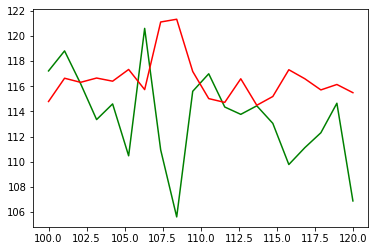

In [69]:
time_step = 1
data_memory = 5
epochs = 10
batch_size = 10
df_model_columns =  ['time_step', 'data_memory', 'samples', 'layers', 'epochs', 'batch_size', 'training_loss', 'val_loss', 'test_loss']
model_des = 'D32, GRU32, GRU32 D1'
model_layer = [layers.Dense(32, activation='sigmoid'),
                layers.GRU(32, activation='softsign', recurrent_activation='relu',recurrent_dropout = 0.1, dropout = 0.1),
                layers.Dense(1)]
plot_range = [100]
plot_range += [plot_range[0] + 20]
plot_pred = True    
#model_df = pd.DataFrame(model_performance).transpose()
#model_df.to_csv('model_performance.csv')
X = EU_em_df.to_numpy()
UK_X = UK_em_df.to_numpy()

X_norm, X_attrs = normalise(UK_X)
X_norm, y_norm = np.split(X, [11], 1)
y_norm = np.roll(y_norm, -time_step)
nrows = X_norm.shape[0]
samples = X_norm.shape[1]
X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
split_point = int(X_norm.shape[0] *0.75)
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)

y, y_pred = run_model(x_train, x_test, y_train, y_test, data_memory, samples, epochs, batch_size, model_des, plot_pred, plot_range)

In [6]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("dense_units", min_value=16, max_value=128, step=16)))
    model.add(layers.GRU(units=hp.Int("GRU_units", min_value=16, max_value=128, step=16), activation='sigmoid', recurrent_activation='sigmoid'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss = 'mse')
    return model
val_split = int(x_train.shape[0] * 0.9)
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, val_split)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="RNN_em",
    project_name="RNN_em",
    )

tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))
models = tuner.get_best_models(num_models=2)
best_model = models[0]
input_shape = (x_train.shape[0], data_memory, samples)
best_model.build(input_shape=input_shape)
best_model.summary()
tuner.results_summary()
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
history = model.fit(x=x_train, y=y_train, epochs=10)

Trial 3 Complete [00h 00m 05s]
val_loss: 0.17924688756465912

Best val_loss So Far: 0.17271053791046143
Total elapsed time: 00h 00m 20s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (439, 5, 80)              960       
                                                                 
 gru (GRU)                   (439, 48)                 18720     
                                                                 
 dense_1 (Dense)             (439, 1)                  49        
                                                                 
Total params: 19,729
Trainable params: 19,729
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in RNN_em\RNN_em
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
den

439

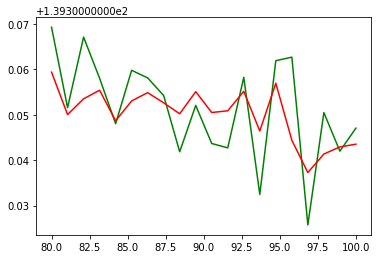

In [54]:
plot_range = [80]
plot_range += [plot_range[0] + 20]
t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')
split_point